## Ex. 6M3.

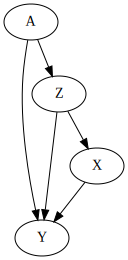

In [1]:
from causalgraphicalmodels import CausalGraphicalModel

dag_1 = CausalGraphicalModel(
    nodes=["X", "Y", "Z", "A"],
    edges=[
        ("X", "Y"),
        ("Z", "X"), 
        ("Z", "Y"),
        ("A", "Z"),
        ("A", "Y")
    ]
)

dag_1.draw()

Apart from the direct path from $X$ to $Y$, there are two other paths from $X$ to $Y$:

1. $X \leftarrow Z \rightarrow Y$

2. $X \leftarrow Z \leftarrow A \rightarrow Y$

Both paths are backdoors and are open. Both paths can be simultaneously closed by conditioning on $Z$.

```R
> dag_1 <- dagitty("dag {X -> Y 
                         Z -> X 
                         Z -> Y 
                         A -> Z 
                         A -> Y }")
> adjustmentSets(dag_1, exposure = "X", outcome = "Y")
{ Z }
```

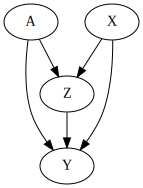

In [2]:
dag_2 = CausalGraphicalModel(
    nodes=["X", "Y", "Z", "A"],
    edges=[
        ("X", "Y"),
        ("X", "Z"), 
        ("Z", "Y"),
        ("A", "Z"),
        ("A", "Y")
    ]
)

dag_2.draw()

Indrirect paths from $X$ to $Y$:

1. $X \rightarrow Z \rightarrow Y$

2. $X \rightarrow Z \leftarrow A \rightarrow Y$

None of the paths are backdoors. Hence we do not have to condition on anything else.

```R
> dag_2 <- dagitty("dag {X -> Y 
                         X -> Z 
                         Z -> Y 
                         A -> Z 
                         A -> Y }")
> adjustmentSets(dag_2, exposure = "X", outcome = "Y")
 {}
```

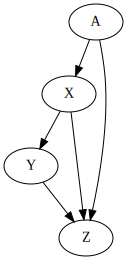

In [3]:
dag_3 = CausalGraphicalModel(
    nodes=["X", "Y", "Z", "A"],
    edges=[
        ("X", "Y"),
        ("X", "Z"), 
        ("Y", "Z"),
        ("A", "X"),
        ("A", "Z")
    ]
)

dag_3.draw()

Indirect paths from $X$ to $Y$:

1. $X \rightarrow Z \leftarrow Y$

2. $X \leftarrow A \rightarrow Z \leftarrow Y$

The first path is not a backdoor. The second path is a backdoor but is closed. So we do not have to condition on anything else.

```R
> dag_3 <- dagitty("dag {X -> Y 
                         X -> Z 
                         Y -> Z 
                         A -> Z 
                         A -> X }")
> adjustmentSets(dag_3, exposure = "X", outcome = "Y")
 {}
```

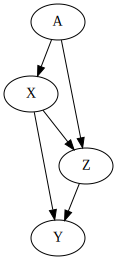

In [4]:
dag_4 = CausalGraphicalModel(
    nodes=["X", "Y", "Z", "A"],
    edges=[
        ("X", "Y"),
        ("X", "Z"), 
        ("Z", "Y"),
        ("A", "X"),
        ("A", "Z")
    ]
)

dag_4.draw()

The indirect paths from $X$ to $Y$ are:

1. $X \leftarrow A \rightarrow Z \rightarrow Y$

2. $X \rightarrow Z \rightarrow Y$

The first path is a backdoor that is open. The second is not a backdoor. To close the first backdoor, we can condition on $A$.

```R
> dag_4 <- dagitty("dag {X -> Y 
                         X -> Z 
                         Z -> Y 
                         A -> Z 
                         A -> X }")
> adjustmentSets(dag_4, exposure = "X", outcome = "Y")
{ A }
```

## Exercise 6H3

In [5]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm

FOXES = '../../data/foxes.csv'

In [6]:
df = pd.read_csv(FOXES)
df.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


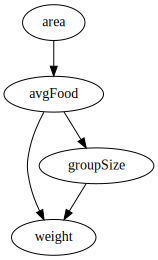

In [7]:
dag_foxes = CausalGraphicalModel(
    nodes=["area", "avgFood", "groupSize", "weight"],
    edges=[
        ("area", "avgFood"),
        ("avgFood", "groupSize"), 
        ("avgFood", "weight"),
        ("groupSize", "weight")
    ]
)

dag_foxes.draw()

The paths from `area` to `weight` are:

1. $\text{area} \rightarrow \text{avgFood} \rightarrow \text{weight}$

2. $\text{area} \rightarrow \text{avgFood} \rightarrow \text{groupSize} \rightarrow \text{weight}$

Neither path is a backdoor. Hence in order to understand the causal impact of `area` on `weight`, we do not need to condition on any of the other variables.

In [8]:
from scipy.stats import zscore


df['A'] = zscore(df['area'])
df['W'] = zscore(df['weight'])
df['F'] = zscore(df['avgfood'])
df['G'] = zscore(df['groupsize'])

<AxesSubplot:xlabel='A', ylabel='W'>

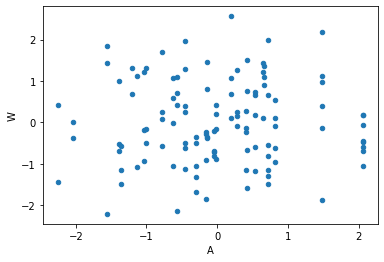

In [9]:
df.plot.scatter(x='A', y='W')

Suppose that we were to regress `weight` against `area` using a model such as:

$$
\begin{array}
         ~W & \sim N(\mu_i, \sigma) \\
      \mu_i & \sim \alpha + \beta \cdot A.  
\end{array}
$$
Then looking at the scatter plot, to cover the full range of values for $\alpha$ and $\beta$, we could set the following priors:
$$
\begin{array}
    ~\alpha & \sim N(0, 1) \\
    \beta   & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{array}
$$
This would mean that $95\%$ of the $\alpha$ values would lie between $[-2, +2]$; and $95\%$ of the $\beta$ values would lie between $[-1, +1]$. $\beta = 1$ corresponds to a line that passes through the left-hand bottom corner and the right-hand top corner; $\beta = -1$ corresponds to a line that passes through the left-hand top corner and the right-hand bottom corner.

In [10]:
with pm.Model() as m_6_1:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = a + b * df['A'].values
    W = pm.Normal('W', mu=mu, sigma=sigma, observed=df['W'].values)
    
    trace_6_1 = pm.sample(2000, init='advi', tune=3000)

az.summary(trace_6_1, var_names=['a', 'b', 'sigma'], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 12600
Interrupted at 12,599 [6%]: Average Loss = 229.4
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 5 seconds.
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.000,0.096,-0.151,0.155,0.001,0.001,9561.0,3458.0,9593.0,4967.0,1.0
b,0.017,0.095,-0.139,0.160,0.001,0.001,9490.0,3703.0,9557.0,5635.0,1.0
sigma,1.015,0.069,0.903,1.119,0.001,0.001,9163.0,9102.0,9116.0,5820.0,1.0


## Discussion

The variable `area` seems to have a very mild positive association in the `weight` of the foxes. Note that the standard deviation is almost 5 times that of the mean and the $89\%$ interval is $[-0.139, 0.160]$. So this is not a very reliable estimate and it is quite possible that area has _no_ association with `weight`.  This means that increasing the area has very little impact on the `weight`.

## Exercise 6H4

If we were to regress `weight` against `avgFood`, then we do not have to control for any other variable. 

<AxesSubplot:xlabel='F', ylabel='W'>

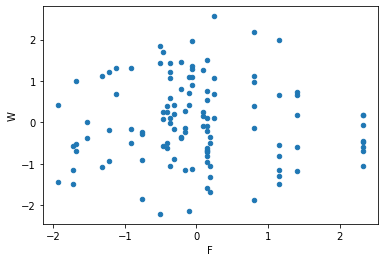

In [11]:
df.plot.scatter(x='F', y='W')

In [12]:
with pm.Model() as m_6_2:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = a + b * df['F'].values
    W = pm.Normal('W', mu=mu, sigma=sigma, observed=df['W'].values)
    
    trace_6_2 = pm.sample(2000, init='advi', tune=3000)

az.summary(trace_6_2, var_names=['a', 'b', 'sigma'], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 13300
Interrupted at 13,299 [6%]: Average Loss = 225.19
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 6 seconds.
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.000,0.093,-0.146,0.145,0.001,0.001,10545.0,3245.0,10598.0,5811.0,1.0
b,-0.023,0.097,-0.176,0.129,0.001,0.001,8687.0,3646.0,8664.0,5152.0,1.0
sigma,1.015,0.068,0.898,1.115,0.001,0.000,10047.0,9910.0,10085.0,5602.0,1.0


Again, this seems to suggest that `avgfood` has a mild negative influence on the `weight` of the foxes. The standard deviation of $b$ is again almost four times that of the mean. The $89\%$ interval is $[-0.176, 0.129]$. So this association is, at best, a very mild one. 

To resolve this issue, we regress `weight` against both `avgfood` and `area`. While adding, both the `area` and `avgfood` to the regression, we do not need to control for any of the other variables.

In [13]:
with pm.Model() as m_6_3:
    a = pm.Normal('a', mu=0, sigma=1)
    b_f = pm.Normal('b_f', mu=0, sigma=0.5)
    b_a = pm.Normal('b_a', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = a + b_f * df['F'].values + b_a * df['A'].values
    W = pm.Normal('W', mu=mu, sigma=sigma, observed=df['W'].values)
    
    trace_6_3 = pm.sample(2000, init='advi', tune=3000)

az.summary(trace_6_3, var_names=['a', 'b_f', 'b_a', 'sigma'], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 13300
Interrupted at 13,299 [6%]: Average Loss = 242.79
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_a, b_f, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 7 seconds.
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.001,0.098,-0.156,0.156,0.001,0.001,8110.0,4262.0,8125.0,5646.0,1.0
b_f,-0.146,0.180,-0.439,0.139,0.004,0.003,2267.0,2164.0,2269.0,2862.0,1.0
b_a,0.144,0.180,-0.126,0.447,0.004,0.003,2196.0,2183.0,2196.0,3087.0,1.0
sigma,1.014,0.068,0.907,1.122,0.001,0.001,9062.0,9061.0,8939.0,5067.0,1.0


In [14]:
df[['A', 'F']].corr()

,A,F
A,1.000000,0.883104
F,0.883104,1.000000


## Discussion

This seems to suggest that foxes that have a larger than average `area` and lower that average `avgfood` tend to be healthier. After having a look at the correlation between `area` and `avgfood`, we get a better picture of what us actually happening. The variables `area` and `avgfood`are strongly correlated. The `weight` seems to be positively correlated with `area` and negatively correlated with `avgfood` so that in the multiple regression, they tend to cancel each other. When we regress `weight` against only one of these variables, they show no association for this reason. But why is `weight` negatively associated with `avgfood`? 

## Exercise 6H5

If we want to find out the causal dependence of `weight` on `groupsize`, then we must control for `avgfood` too. This is because there are two paths from `groupsize` to `weight`:

1. $\text{groupsize} \rightarrow \text{weight}$

2. $\text{groupsize} \leftarrow \text{avgfood} \rightarrow \text{weight}$

The second path is a backdoor that is open. To close it, we must condition on `avgfood`.

In [15]:
with pm.Model() as m_6_4:
    a = pm.Normal('a', mu=0, sigma=1)
    b_f = pm.Normal('b_f', mu=0, sigma=2)
    b_g = pm.Normal('b_g', mu=0, sigma=2)
    sigma = pm.Uniform('sigma', lower=0, upper=5)
    
    mu = a + b_f * df['F'].values + b_g * df['G'].values
    W = pm.Normal('W', mu=mu, sigma=sigma, observed=df['W'].values)
    
    trace_6_4 = pm.sample(2000, init='advi', tune=3000)

az.summary(trace_6_4, var_names=['a', 'b_f', 'b_g', 'sigma'], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 13800
Interrupted at 13,799 [6%]: Average Loss = 196.37
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_g, b_f, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 8 seconds.
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.000,0.091,-0.140,0.148,0.001,0.001,8035.0,4009.0,8042.0,5482.0,1.0
b_f,0.626,0.211,0.293,0.965,0.005,0.003,2040.0,2040.0,2045.0,2413.0,1.0
b_g,-0.723,0.209,-1.077,-0.410,0.005,0.003,1994.0,1994.0,2002.0,2436.0,1.0
sigma,0.970,0.067,0.870,1.080,0.001,0.000,9413.0,9388.0,9326.0,4943.0,1.0


## Discussion

Thus `avgfood` is positively associated with the `weight`. The `groupsize` is negatively associated with `weight`. This makes sense, because given a food source, the larger the group size, the smaller the food available for an individual fox. 

What is also possible is that the causal DAG presented may not be the true one. What if `groupsize` had a direct causal impact on `area` and `weight`? One plausible explanantion is that larger groups tend to control larger territories that have a richer food source. Therefore, as the `groupsize` increases, the `area` also increases. However, `groupsize` is probably negatively associated with `weight`. A larger group has to share resources so that on the average, individuals in a larger group tend to get less food. So the proposed causal DAG is as follows:

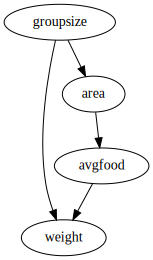

In [16]:
foxes_2 = CausalGraphicalModel(
    nodes=["groupsize", "area", "weight", "avgfood"],
    edges=[
        ("groupsize", "area"),
        ("groupsize", "weight"), 
        ("area", "avgfood"),
        ("avgfood", "weight")
    ]
)

foxes_2.draw()

In [17]:
with pm.Model() as m_6_5:
    a = pm.Normal('a', mu=0, sigma=1)
    b_a = pm.Normal('b_a', mu=0, sigma=2)
    b_g = pm.Normal('b_g', mu=0, sigma=2)
    sigma = pm.Uniform('sigma', lower=0, upper=5)
    
    mu = a + b_a * df['A'].values + b_g * df['G'].values
    W = pm.Normal('W', mu=mu, sigma=sigma, observed=df['W'].values)
    
    trace_6_5 = pm.sample(2000, init='advi', tune=3000)

az.summary(trace_6_5, var_names=['a', 'b_a', 'b_g', 'sigma'], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 14500
Interrupted at 14,499 [7%]: Average Loss = 194.36
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_g, b_a, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 8 seconds.
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.093,-0.144,0.149,0.001,0.001,9451.0,4537.0,9456.0,6254.0,1.0
b_a,0.479,0.165,0.231,0.753,0.004,0.003,2050.0,2048.0,2050.0,2980.0,1.0
b_g,-0.556,0.165,-0.815,-0.286,0.004,0.003,2099.0,2099.0,2096.0,3154.0,1.0
sigma,0.972,0.065,0.865,1.071,0.001,0.000,9258.0,9109.0,9349.0,5539.0,1.0


## Discussion

The estimates of $b_a$ and $b_g$ seem to confirm the causal DAG that we suggested. However, at this point, using the data alone we cannot confirm which DAG is correct. Furthermore, in the last causal DAG, we hypothesised a causal effect of `groupsize` on `area`. What is more likely is that `groupsize` casually affects `avgfood/area`, that is, larger groups tend to control larger areas that are also food rich. The causal DAG now becomes:  

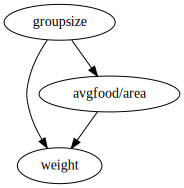

In [18]:
foxes_3 = CausalGraphicalModel(
    nodes=["groupsize", "avgfood/area", "weight"],
    edges=[
        ("groupsize", "avgfood/area"),
        ("groupsize", "weight"), 
        ("avgfood/area", "weight")
    ]
)

foxes_3.draw()

To understand the causal relationship between the food density (`avgfood/area`) and `weight` we must include the `groupsize`.

In [19]:
df['F/A'] = zscore(df['avgfood'] / df['area'])

In [20]:
with pm.Model() as m_6_6:
    a = pm.Normal('a', mu=0, sigma=1)
    b_d = pm.Normal('b_d', mu=0, sigma=2)
    b_g = pm.Normal('b_g', mu=0, sigma=2)
    sigma = pm.Uniform('sigma', lower=0, upper=5)
    
    mu = a + b_d * df['F/A'].values + b_g * df['G'].values
    W = pm.Normal('W', mu=mu, sigma=sigma, observed=df['W'].values)
    
    trace_6_6 = pm.sample(2000, init='advi', tune=3000)

az.summary(trace_6_6, var_names=['a', 'b_d', 'b_g', 'sigma'], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 13200
Interrupted at 13,199 [6%]: Average Loss = 196.33
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_g, b_d, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 5 seconds.
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.095,-0.148,0.154,0.001,0.001,11654.0,3567.0,11670.0,6283.0,1.0
b_d,-0.072,0.096,-0.223,0.084,0.001,0.001,11077.0,6406.0,11079.0,6198.0,1.0
b_g,-0.172,0.095,-0.318,-0.015,0.001,0.001,11403.0,8229.0,11404.0,5863.0,1.0
sigma,1.009,0.068,0.905,1.119,0.001,0.000,10627.0,10534.0,10589.0,5186.0,1.0


Well, that does not seem to be the right model!